# Assignment 2

# Part 1: Image segmentation

## Question 1: Color clustering with K-means (15 points)

In [8]:
%load_ext autoreload
%autoreload 2

import cv2, pickle
import matplotlib.pyplot as plt
import numpy as np
from kmeans import kmeans
import importlib
from os import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def run_kmeans(K, niter, filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, nchannel = img.shape
    scale = 500/max(height, width)
    img = cv2.resize(img, (int(width*scale), int(height*scale)))
    x = img.reshape((-1, 3)).astype(np.float32)
    labels, centroids = kmeans(x, K, niter)
    centroids = np.uint8(centroids)
    labels = np.int8(labels)
    result = centroids[labels.flatten()]
    result_image = result.reshape((img.shape))
    plt.figure(figsize=(10, 10))
    plt.subplot(1,2,1)
    plt.imshow(img); plt.title('Original Image'); plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(result_image); plt.title('Segmented Image (K={})'.format(K)); plt.axis('off')
    plt.show()
    plt.figure(figsize=(10, 5))
    for k in range(K):
        plt.subplot(1,K,k+1)
        result_image = np.ones_like(img) * 128
        result_image[labels.reshape((img.shape[:2]))==k] = centroids[k]
        plt.imshow(result_image); plt.title(f'Seg ID: {k}'); plt.axis('off')

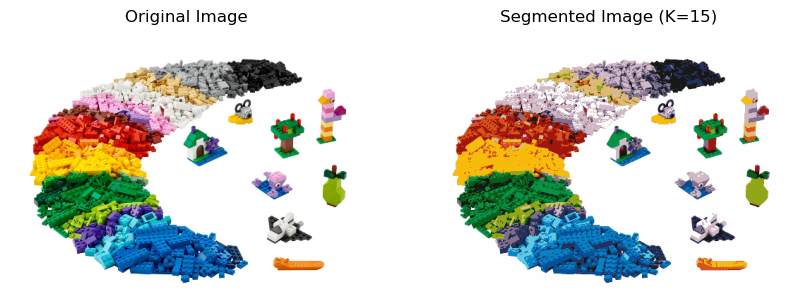

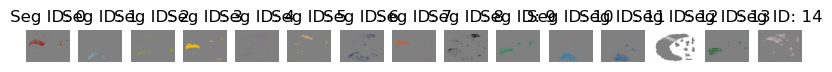

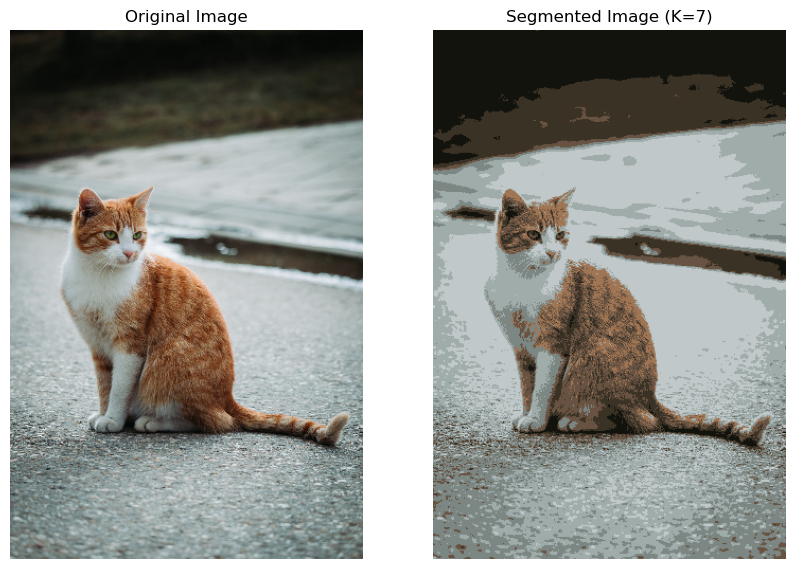

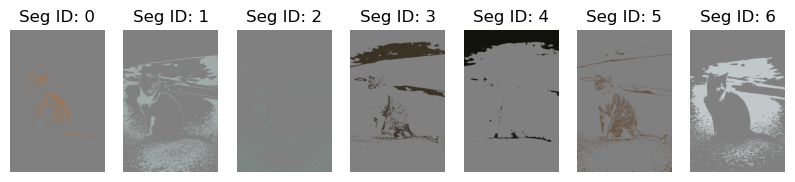

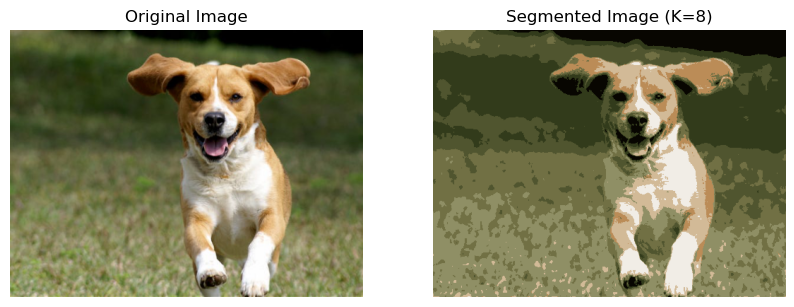

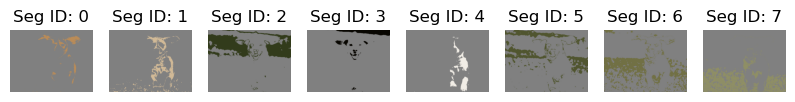

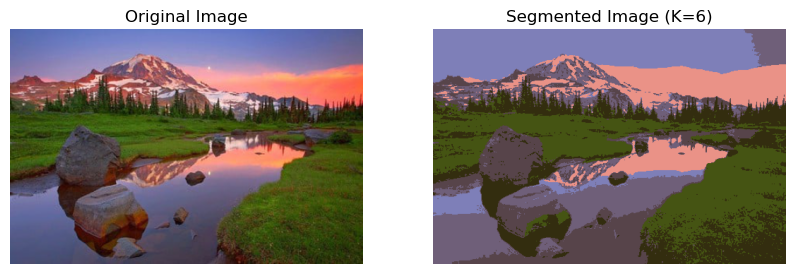

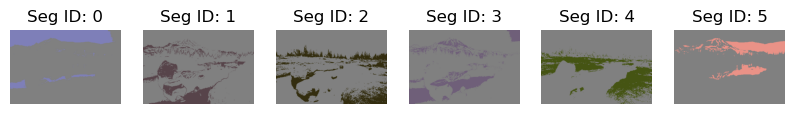

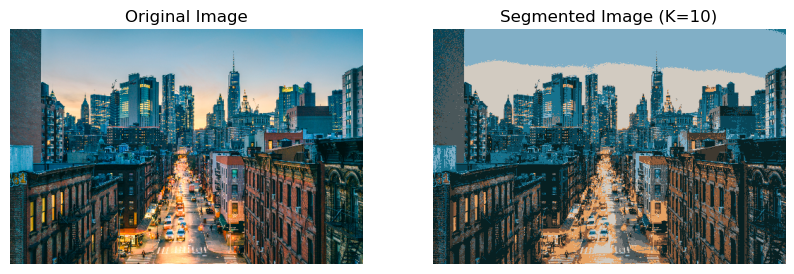

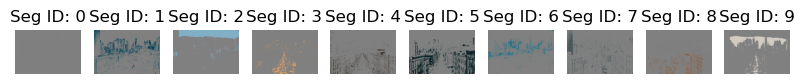

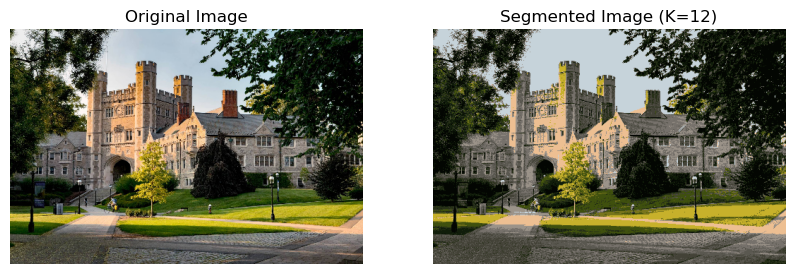

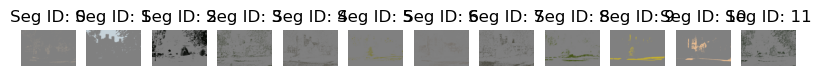

In [10]:
filenames = ['imgs/lego.png', 'imgs/cat.jpeg', 'imgs/dog.jpeg',  'imgs/nature.jpeg', 'imgs/nyc.jpeg', 'imgs/princeton.jpeg']
K = [15,7,8,6,10,12]
niter = 20
for i in range(len(filenames)):
    run_kmeans(K[i], niter, filenames[i])

# Part 2: Classic recognition 

In [1]:
%load_ext autoreload
%autoreload 2

import os, pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import get_CIFAR10_data, train, evaluate

In [2]:
meta = pickle.load(open('data/cifar-10-batches-py/batches.meta', 'rb'), encoding='bytes')
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py')

Train data shape:  (45000, 32, 32, 3)
Train labels shape:  (45000,)
Validation data shape:  (5000, 32, 32, 3)
Validation labels shape:  (5000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Question 2. Color features (5 points)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
reg 0.000000e+00 train accuracy: 0.141333 val accuracy: 0.174000

best validation accuracy achieved during training: 0.174000

final test set accuracy: 0.130000
[0 2 3 6 8 9]


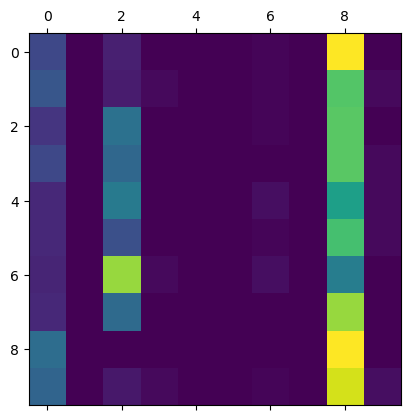

In [10]:
# ALL OPERATIONS
from assn2 import load_average_color_with_bias
from sklearn.metrics import confusion_matrix

regularization_strengths = [0.09]

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)
X_train = load_average_color_with_bias(X_train)
X_val = load_average_color_with_bias(X_val)
X_test = load_average_color_with_bias(X_test)
best_color = train(X_train, y_train, X_val, y_val, X_test, y_test, regularization_strengths)
C = confusion_matrix(y_test, best_color.predict(X_test))
plt.matshow(C)
temp = np.unique(best_color.predict(X_test))
print(temp)

## Question 3. Bag of SIFT features (15 points)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
reg 1.200000e+03 train accuracy: 0.235111 val accuracy: 0.246000

best validation accuracy achieved during training: 0.246000
final test set accuracy: 0.234000


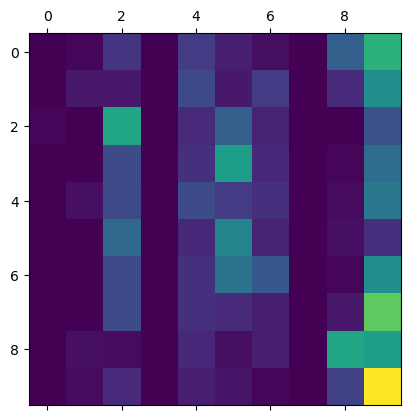

In [14]:
from features import extract_sift_for_dataset
from assn2 import load_flatten
from assn2 import load_histogram_with_bias
from kmeans import kmeans
from sklearn.metrics import confusion_matrix

step_size = 4
K = 16
niter = 4
regularization_strengths = [1.2e3]

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)
X_train_features = extract_sift_for_dataset(X_train, step_size=step_size)
X_val_features = extract_sift_for_dataset(X_val, step_size=step_size)
X_test_features = extract_sift_for_dataset(X_test, step_size=step_size)
X_train_features_flattened = load_flatten(X_train_features)
labels_train, centroids = kmeans(X_train_features_flattened, K, niter)
train_hist = load_histogram_with_bias(X_train_features, centroids)
val_hist = load_histogram_with_bias(X_val_features, centroids)
test_hist = load_histogram_with_bias(X_test_features, centroids)
best_color = train(train_hist, y_train, val_hist, y_val, test_hist, y_test, regularization_strengths, skip_test=True)
evaluate(best_color, test_hist, y_test)
C = confusion_matrix(y_test, best_color.predict(test_hist))
plt.matshow(C)

## Question 4. SPM representation (15 points)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
reg 1.000000e+03 train accuracy: 0.256000 val accuracy: 0.258000

best validation accuracy achieved during training: 0.258000
final test set accuracy: 0.241000


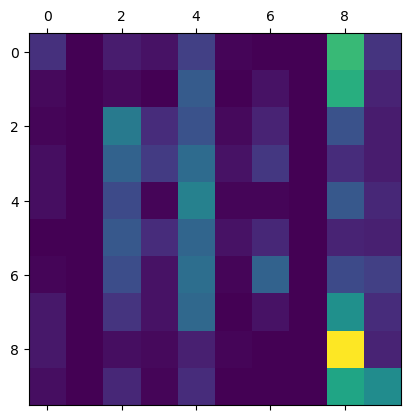

In [15]:
from features import spatial_pyramid_matching_with_bias
from sklearn.metrics import confusion_matrix

L = 2
K = 16
niter = 4
regularization_strengths = [1e3]

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)
X_train_features = extract_sift_for_dataset(X_train, step_size=1)
X_train_features_flattened = load_flatten(X_train_features)
X_val_features = extract_sift_for_dataset(X_val, step_size=1)
X_test_features = extract_sift_for_dataset(X_test, step_size=1)
_, centroids = kmeans(X_train_features_flattened, K, niter)
X_train_spm = [spatial_pyramid_matching_with_bias(L, 
                                        X_train_features[i].reshape((32, 32, 128)), 
                                        centroids) 
            for i in range(len(X_train))]
X_val_spm = [spatial_pyramid_matching_with_bias(L,
                                      X_val_features[i].reshape((32, 32, 128)), 
                                      centroids) 
            for i in range(len(X_val))]
X_test_spm = [spatial_pyramid_matching_with_bias(L,
                                       X_test_features[i].reshape((32, 32, 128)),
                                       centroids)  
              for i in range(len(X_test))]
X_train_spm = np.stack(X_train_spm, 0)
X_val_spm = np.stack(X_val_spm, 0)
X_test_spm = np.stack(X_test_spm, 0)
best_color = train(X_train_spm, y_train, X_val_spm, y_val, X_test_spm, y_test, regularization_strengths, skip_test=True)
evaluate(best_color, X_test_spm, y_test)
C = confusion_matrix(y_test, best_color.predict(X_test_spm))
plt.matshow(C)

## Question 5. Histogram of Oriented Gradients (10 points) 

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
reg 1.000000e-04 train accuracy: 0.107556 val accuracy: 0.106000

best validation accuracy achieved during training: 0.106000

final test set accuracy: 0.099000


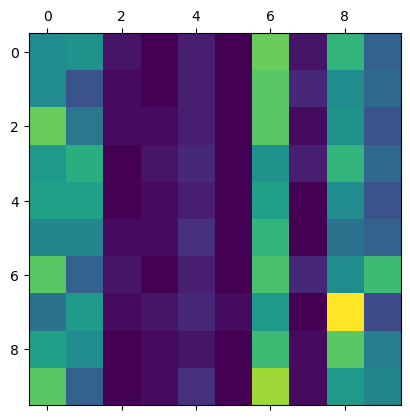

In [15]:
from assn2 import load_hog_representation_with_bias
from sklearn.metrics import confusion_matrix

cell_size = 2
block_size = 4
regularization_strengths = [1e4]

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)
X_train_hog =  load_hog_representation_with_bias(X_train, cell_size, block_size)
X_val_hog = load_hog_representation_with_bias(X_val, cell_size, block_size)
X_test_hog = load_hog_representation_with_bias(X_test, cell_size, block_size)
best_color = train(X_train_hog, y_train, X_val_hog, y_val, X_test_hog, y_test, regularization_strengths)
C = confusion_matrix(y_test, best_color.predict(X_test_hog))
plt.matshow(C)

## Question 6. Pixels (5 points)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
[59. 62. 63. ... 92. 72.  1.]
[255. 255. 255. ... 255. 255.   1.]
[158. 112.  49. ...  67. 110.   1.]
reg 0.000000e+00 train accuracy: 0.267111 val accuracy: 0.208000

best validation accuracy achieved during training: 0.208000

final test set accuracy: 0.216000


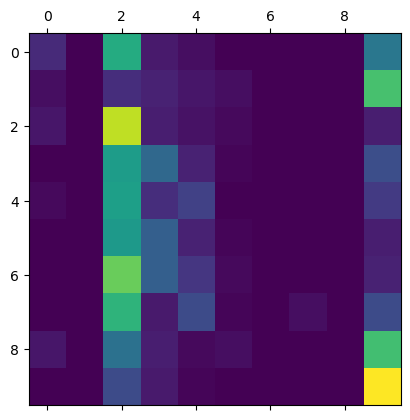

In [14]:
from assn2 import load_vector_image_with_bias
from sklearn.metrics import confusion_matrix

regularization_strengths = [0]

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='data/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)
X_train, X_val, X_test = load_vector_image_with_bias(X_train, X_val, X_test)
print(X_train[0])
print(X_val[0])
print(X_test[0])
best_color = train(X_train, y_train, X_val, y_val, X_test, y_test, regularization_strengths)
C = confusion_matrix(y_test, best_color.predict(X_test))
plt.matshow(C)